In [17]:
# Data pre-processing
import pandas as pd
import numpy as np
import re

# Treinamento do modelo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualização
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import plot, iplot
import cufflinks as cf
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
import plotly.io as pio

In [163]:
df_lugarcerto = pd.read_csv("imoveisLugarCerto.csv")

In [164]:
#Analisando os dados duplicados e excluindo do DataFrame
df_lugarcerto.drop_duplicates(keep='first', inplace=True)
df_lugarcerto = df_lugarcerto.drop(index=df_lugarcerto.loc[df_lugarcerto['quartos'] == 'quartos'].index)

In [165]:
df_lugarcerto.head(5)

,codigo,titulo,localizacao,price,quartos,banheiros,vagas,suite,area,anunciante
0,M24AP2524,Apartamento com 4 quartos à venda no bairro S...,"João de Abreu, 1, Setor Oeste, Goiânia - GO","R$ 3.585.000,00",4.0,6.0,3.0,4.0,356m²,M2 Investimentos Imobiliários
1,U-0010688,Apartamento com 2 quartos à venda no bairro S...,"Avenida T 10, 0, Setor Bueno, Goiânia - GO","R$ 985.000,00",2.0,2.0,1.0,2.0,74m²,Urbs Conceito 1
2,U-0011610,Apartamento com 3 quartos à venda no bairro S...,"Rua 3, 0, Setor Oeste, Goiânia - GO","R$ 2.000.000,00",3.0,1.0,3.0,NaN,178m²,Urbs Conceito 1
3,NaN,Apartamento com 3 quartos à venda no bairro A...,"Rua Joaquim Nabuco, 1300, Aldeota, Fortaleza ...","R$ 499.000,00",3.0,3.0,2.0,2.0,139m²,Fênix Imóveis
4,335,Casa com 3 quartos à venda no bairro Vila Mar...,"Avenida Odorico Nery, 12, Vila Maria, Apareci...","R$ 370.000,00",3.0,2.0,2.0,1.0,110m²,Rvs Imóveis


## Tratamento dos dados

In [166]:
# Tratar coluna código
df_lugarcerto['codigo'] = df_lugarcerto['codigo'].fillna('indef')

In [167]:
# Pre-processamento do atributo price
df_lugarcerto['preco'] = (
    df_lugarcerto['price']
    .str.extract(r'([\d.,]+)')[0]       # Extrai apenas os números e separadores (primeiro grupo)
    .str.replace('.', '', regex=False)  # Remove os pontos (separadores de milhar)
    .str.replace(',', '.', regex=False) # Substitui vírgulas por pontos (separador decimal)
    .astype(float)                      # Converte para float
)

In [168]:
# Pré-processamento do atributo área
df_lugarcerto['area'] = (
    df_lugarcerto['area']
    .str.replace('m²', '', regex=False) # Remove o sufixo "m²"
    .fillna(0)                          # Remove espaços em branco
    .astype(float)                      # Substitui strings vazias por zero
)

In [169]:
# Função para tratar a localização
def tratar_localizacao(localizacao):
    try:
        partes = localizacao.split(',')
        rua = partes[0].strip()
        numero = partes[1].strip() if len(partes) > 1 else None
        bairro = partes[2].strip() if len(partes) > 2 else None

        # Separar cidade e estado
        cidade_estado = partes[-1].split('-') if '-' in partes[-1] else [None, None]
        cidade = cidade_estado[0].strip() if cidade_estado[0] else None
        estado = cidade_estado[1].strip() if len(cidade_estado) > 1 else None

        return pd.Series([rua, numero, bairro, cidade, estado])

    except Exception as e:
        return pd.Series([None, None, None, None, None])  # Para casos extremos

df_lugarcerto[['rua', 'numero', 'bairro', 'cidade', 'estado']] = df_lugarcerto['localizacao'].apply(tratar_localizacao)

In [170]:
# Função para extrair as informações
def extrair_informacoes(titulo):
    # Extrair o tipo de imóvel
    tipo_imovel = None
    if 'Apartamento' in titulo:
        tipo_imovel = 'Apartamento'
    elif 'Apart Hotel' in titulo:
        tipo_imovel = 'Apart Hotel'
    elif 'Casa' in titulo:
        tipo_imovel = 'Casa'
    else:
        tipo_imovel = 'Outros'
    """elif 'Cobertura' in titulo:
        tipo_imovel = 'Cobertura'
    elif 'Quitinete' in titulo:
        tipo_imovel = 'Quitinete'
    elif 'Galpão' in titulo:
        tipo_imovel = 'Galpão'
    elif 'Casa de Condomínio' in titulo:
        tipo_imovel = 'Casa em Condomínio'
    elif 'Garagem' in titulo:
        tipo_imovel = 'Garagem'
    elif 'Chácara' in titulo:
        tipo_imovel = 'Chácara'
    elif 'Fazenda' in titulo:
        tipo_imovel = 'Fazenda'
    elif 'Rural' in titulo:
        tipo_imovel = 'Rural'
    elif 'Sítio' in titulo:
        tipo_imovel = 'Sítio'
    elif 'Lote' in titulo:
        tipo_imovel = 'Lote'
    elif 'Loteamento' in titulo:
        tipo_imovel = 'Loteamento'
    elif 'Casa' in titulo:
        tipo_imovel = 'Casa'
    elif 'Sala Comercial' in titulo:
        tipo_imovel = 'Sala Comercial'
    elif 'Sala' in titulo:
        tipo_imovel = 'Sala'
    elif 'Terreno' in titulo:
        tipo_imovel = 'Terreno'
    elif 'Loja' in titulo:
        tipo_imovel = 'Loja'
    elif 'Ponto Comercial' in titulo:
        tipo_imovel = 'Ponto Comercial'
    elif 'Andar' in titulo:
        tipo_imovel = 'Andar'
    elif 'Prédio' in titulo:
        tipo_imovel = 'Prédio'
    elif 'Área Privativa' in titulo:
        tipo_imovel = 'Área Privativa'
    elif 'Pousada' in titulo:
        tipo_imovel = 'Pousada'
"""

    return pd.Series([tipo_imovel])

# Aplicar a função para extrair as informações
df_lugarcerto[['tipo_imovel']] = df_lugarcerto['titulo'].apply(extrair_informacoes)

In [171]:
df_lugarcerto.loc[df_lugarcerto['preco'].isna()]

,codigo,titulo,localizacao,price,quartos,banheiros,vagas,suite,area,anunciante,preco,rua,numero,bairro,cidade,estado,tipo_imovel
46997,LP 242,Apartamento com 2 quartos à venda no bairro R...,"Rua Salvador de Sá, 145, Rosarinho, Recife - PE",Consultar Preço,2.0,3.0,1.0,1.0,80.0,Luiza Parizi Imóveis,NaN,Rua Salvador de Sá,145,Rosarinho,Recife,PE,Apartamento
46999,UNION,Apartamento com 1 quarto à venda no bairro No...,"Crnw 511 Noroeste, Noroeste, Brasília/Plano P...",Consultar Preço,1.0,1.0,1.0,1.0,35.0,Achei Imóveis Df,NaN,Crnw 511 Noroeste,Noroeste,Brasília/Plano Piloto - DF,Brasília/Plano Piloto,DF,Apartamento
47000,indef,Apartamento com 4 quartos à venda no bairro J...,"Rua 70 C/ Rua 74, Jardim Goiás, Goiânia - GO",Consultar Preço,4.0,6.0,2.0,4.0,174.0,Merzian Construtora,NaN,Rua 70 C/ Rua 74,Jardim Goiás,Goiânia - GO,Goiânia,GO,Apartamento
47001,LCMX09,Apartamento com 4 quartos à venda no bairro S...,"Rua Santa Maria de Itabira, 320, Sion, Belo H...",Consultar Preço,4.0,3.0,3.0,1.0,178.0,Mattra Center,NaN,Rua Santa Maria de Itabira,320,Sion,Belo Horizonte,MG,Apartamento
47003,LCMX05,Apartamento com 4 quartos à venda no bairro S...,"Rua Santa Maria de Itabira, 320, Sion, Belo H...",Consultar Preço,4.0,3.0,3.0,1.0,178.0,Mattra Center,NaN,Rua Santa Maria de Itabira,320,Sion,Belo Horizonte,MG,Apartamento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55664,40800,Lote à venda no bairro Centro,"Centro, Ortigueira - PR",Consultar Preço,NaN,NaN,NaN,NaN,0.0,3s Imoveis,NaN,Centro,Ortigueira - PR,None,Ortigueira,PR,Outros
55665,768,"Casa à venda no bairro Cidade Vera Cruz, 360m²","Cidade Vera Cruz, Aparecida de Goiânia - GO",Consultar Preço,NaN,NaN,NaN,NaN,360.0,House & Aviation Imobiliária,NaN,Cidade Vera Cruz,Aparecida de Goiânia - GO,None,Aparecida de Goiânia,GO,Casa
55667,indef,Casa à venda no bairro Lago Sul,"Lago Sul, Brasília/Plano Piloto - DF",Consultar Preço,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Lago Sul,Brasília/Plano Piloto - DF,None,Brasília/Plano Piloto,DF,Casa
55668,indef,Lote em Condomínio à venda no bairro Plano Di...,"Plano Diretor Norte, Palmas - TO",Consultar Preço,NaN,NaN,NaN,NaN,895.0,G.a.m. Empreendimentos Imobiliários,NaN,Plano Diretor Norte,Palmas - TO,None,Palmas,TO,Outros


In [172]:
df_lugarcerto['quartos'] = df_lugarcerto['quartos'].fillna('0').astype(int)
df_lugarcerto['banheiros'] = df_lugarcerto['banheiros'].fillna('0').astype(int)
df_lugarcerto['vagas'] = df_lugarcerto['vagas'].fillna('0').astype(int)
df_lugarcerto['suite'] = df_lugarcerto['suite'].fillna('0').astype(int)
df_lugarcerto['bairro'] = df_lugarcerto['bairro'].fillna('indef')

In [173]:
col_cat = ['tipo_imovel', 'bairro', 'cidade',
           'estado', 'rua', 'numero', 'anunciante', 'localizacao']

for col in col_cat:
  df_lugarcerto[col] = df_lugarcerto[col].fillna(f'{col}_indef')

In [174]:
def substituir_outliers(df, colunas):
    df_tratado = df.copy()
    
    for coluna in colunas:
        # Calcula os quartis e o IQR
        Q1 = df_tratado[coluna].quantile(0.25)
        Q3 = df_tratado[coluna].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define os limites inferior e superior
        lim_inferior = Q1 - 1.5 * IQR
        lim_superior = Q3 + 1.5 * IQR
        
        # Ajusta os valores fora dos limites
        df_tratado[coluna] = df_tratado[coluna].apply(
            lambda x: max(min(x, lim_superior), lim_inferior)
        )
    
    return df_tratado

colunas = ['preco', 'area', 'vagas', 'banheiros', 'suite', 'quartos']
df_sem_outliers = substituir_outliers(df_lugarcerto, colunas)

In [175]:
preco_mean, preco_std = df_sem_outliers['preco'].mean(), df_sem_outliers['preco'].std()

precos_nulos = np.random.normal(preco_mean, preco_std, df_sem_outliers['preco'].isna().sum())

# Atribuir os valores gerados aos índices onde há NaNs
df_sem_outliers.loc[df_sem_outliers['preco'].isna(), 'preco'] = precos_nulos

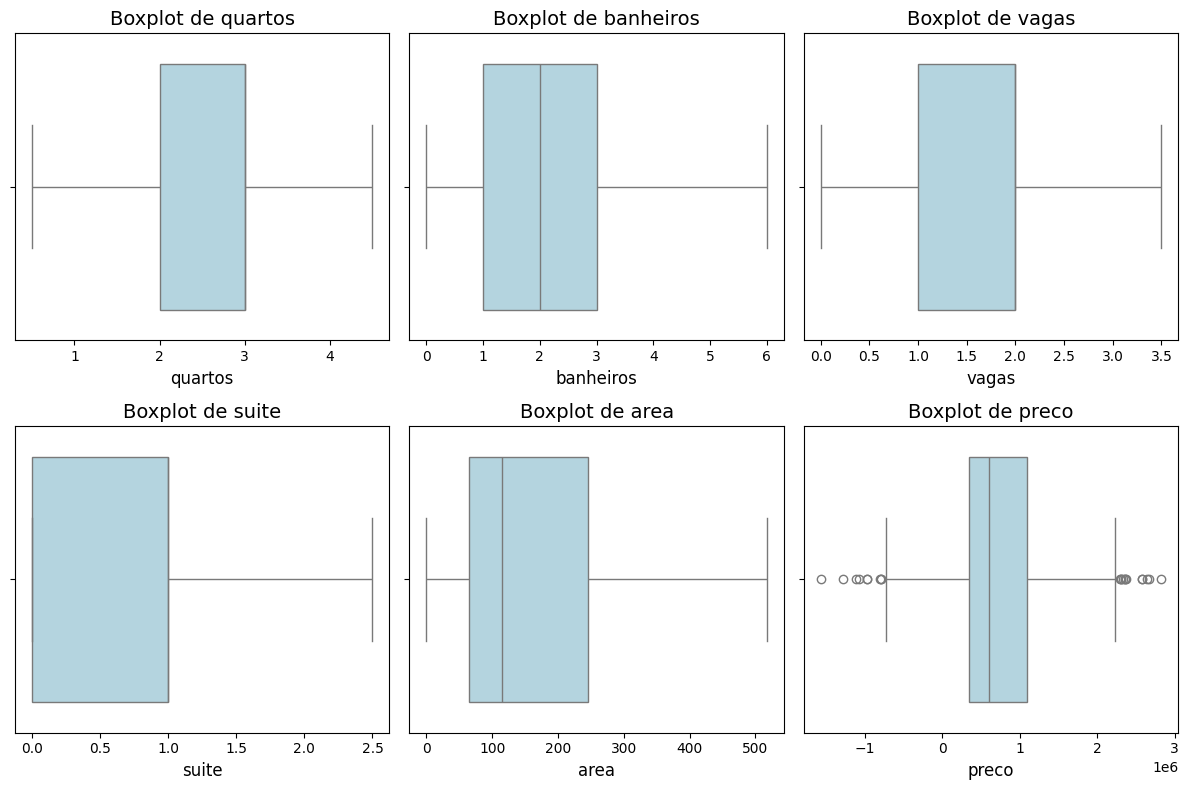

In [176]:
colunas_numericas = df_lugarcerto.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 8))

# Iterar sobre as colunas numéricas e criar um boxplot para cada uma
for i, coluna in enumerate(colunas_numericas):
    plt.subplot(2, 3, i+1)  # Configura o layout do gráfico (2 linhas e 3 colunas)
    sns.boxplot(x=df_sem_outliers[coluna], color='lightblue')
    plt.title(f'Boxplot de {coluna}', fontsize=14)
    plt.xlabel(coluna, fontsize=12)

plt.tight_layout()
plt.show()

## Transformação dos dados

In [177]:
features = ['quartos', 'banheiros', 'vagas', 'suite', 'area', 'estado', 'tipo_imovel']
target = ['preco']

df = df_sem_outliers[features + target]

In [178]:
estados_encoded = pd.get_dummies(df['estado'], prefix='estado')
df = pd.concat([df, estados_encoded], axis=1)
df.drop(columns=['estado'], inplace=True)

In [182]:
tipo_imovel_encoded = pd.get_dummies(df['tipo_imovel'], prefix='tipo_imovel')
df = pd.concat([df, tipo_imovel_encoded], axis=1)
df.drop(columns=['tipo_imovel'], inplace=True)

In [183]:
df.head(5)

,quartos,banheiros,vagas,suite,area,preco,estado_AL,estado_AM,estado_BA,estado_CE,...,estado_SC,estado_SE,estado_SP,estado_TO,estado_estado_indef,estado_lá,tipo_imovel_Apart Hotel,tipo_imovel_Apartamento,tipo_imovel_Casa,tipo_imovel_Outros
0,4.0,6.0,3.0,2.5,356.0,2225000.0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,2.0,2.0,1.0,2.0,74.0,985000.0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,3.0,1.0,3.0,0.0,178.0,2000000.0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,3.0,3.0,2.0,2.0,139.0,499000.0,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,3.0,2.0,2.0,1.0,110.0,370000.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## Treinamento do modelo

In [184]:
# Selecionar as variáveis preditoras e a variável alvo
X = df.drop(columns=['preco'])  # Todas as colunas exceto 'price'
y = df['preco']                 # Variável alvo

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
# Instanciar o modelo
lin_reg = LinearRegression()

# Treinar o modelo
lin_reg.fit(X_train, y_train)

# Previsões
y_pred_lin = lin_reg.predict(X_test)

# Avaliar o modelo
print("Regressão Linear:")
print(f"R²: {r2_score(y_test, y_pred_lin):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin)):.2f}")

Regressão Linear:
R²: 0.46
RMSE: 462481.90


In [186]:
# Instanciar o modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo
rf.fit(X_train, y_train)

# Previsões
y_pred_rf = rf.predict(X_test)

# Avaliar o modelo
print("\nRandom Forest:")
print(f"R²: {r2_score(y_test, y_pred_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")


Random Forest:
R²: 0.60
RMSE: 396353.09
